# Import Libraries

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "2"  # specify which GPU(s) to be used
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
import torchvision
import torch.nn.functional as F
from torch.autograd import Variable
from utilities.simEps_net_factory import net_factory

from PIL import Image
import cv2
import albumentations as A

import time
import os
from tqdm.notebook import tqdm

from torchsummary import summary
# import segmentation_models_pytorch as smp

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model

In [2]:
# model1 = net_factory(net_type='unet_f', in_chns=3, class_num=4)
model1 = net_factory(net_type='unet_f', in_chns=1, class_num=7)
model2 = net_factory(net_type='unet_f', in_chns=1, class_num=7)
model3 = net_factory(net_type='unet_f', in_chns=1, class_num=7)
# model = smp.Unet("resnet18", encoder_weights= None, classes=4, activation=None)

model1 = nn.DataParallel(model1)
model2 = nn.DataParallel(model2)
model3 = nn.DataParallel(model3)
# model = nn.DataParallel(model)

In [3]:
#Load model state dict

checkpoint_0 = torch.load("/.../model_weights/DAGM/simEps_10p_1.pth")
checkpoint_1 = torch.load("/.../model_weights/DAGM/simEps_10p_2.pth")
checkpoint_2 = torch.load("/.../model_weights/DAGM/simEps_10p_3.pth")
print(checkpoint_0['epoch'])
print(checkpoint_1['epoch'])
print(checkpoint_2['epoch'])

#Loading the trained model weight
model1.load_state_dict(checkpoint_0['state_dict'])
model2.load_state_dict(checkpoint_1['state_dict'])
model3.load_state_dict(checkpoint_2['state_dict'])

print('The state dics are loaded')
# print(checkpoint_0['best_loss_1'])

664
664
664
The state dics are loaded


In [4]:
# # Model Ensembling based on max confidence

# class Model:
#     def __init__(self, models, voting=False):
#         self.models = models
#         self.voting = voting
    
#     def __call__(self, x):
#         res = []
#         # x = x.to(DEVICE)
#         with torch.no_grad():
#             for m in self.models:
#                 m.to(device)
#                 m.eval()
#                 _, _, _, _, _, output, _, _, _ = m(x)
#                 res.append(output)
#         # res = torch.stack(res)
#         pred = torch.max(torch.max(res[0], res[1]), res[2])
#         return pred

In [5]:
# Model Ensembling based on soft voting (average prediction)

class Model:
    def __init__(self, models, voting=False):
        self.models = models
        self.voting = voting
    
    def __call__(self, x):
        res = []
        # x = x.to(DEVICE)
        with torch.no_grad():
            for m in self.models:
                m.to(device)
                m.eval()
                _, _, _, _, _, output, _, _, _ = m(x)
                res.append(output)
        # res = torch.stack(res)
        pred = (res[0]+res[1]+res[2])/3
        # pred = (res[0]+res[1])/2
        return pred

In [7]:
models = [model1, model2, model3]
# # set ensemble mode to simple average
model = Model(models, voting=False)

# Metrics

In [8]:
def pixel_accuracy(output, mask):
    with torch.no_grad():
        output = torch.argmax(F.softmax(output, dim=1), dim=1)
        correct = torch.eq(output, mask).int()
        accuracy = float(correct.sum()) / float(correct.numel())
    return accuracy

In [9]:
def mIoU(pred_mask, mask, smooth=1e-10, n_classes=7):
    with torch.no_grad():
        pred_mask = F.softmax(pred_mask, dim=1)
        pred_mask = torch.argmax(pred_mask, dim=1)
        pred_mask = pred_mask.contiguous().view(-1)
        mask = mask.contiguous().view(-1)

        iou_per_class = []
        for clas in range(1, n_classes): #loop per pixel class , start from class 1, excluding the background class
            true_class = pred_mask == clas
            true_label = mask == clas

            if true_label.long().sum().item() == 0: #no exist label in this loop
                iou_per_class.append(np.nan)

            # elif true_label.long().sum().item() > 0 and true_class.long().sum().item() ==0: #no exist label in this loop
            #     iou = 0
            #     iou_per_class.append(iou)
            else:
                intersect = torch.logical_and(true_class, true_label).sum().float().item()
                union = torch.logical_or(true_class, true_label).sum().float().item()

                iou = (intersect + smooth) / (union +smooth)
                iou_per_class.append(iou)
        return np.nanmean(iou_per_class)

In [10]:
def mDice(pred_mask, mask, smooth=1e-10, n_classes=7):
    with torch.no_grad():
        pred_mask = F.softmax(pred_mask, dim=1)
        pred_mask = torch.argmax(pred_mask, dim=1)
        pred_mask = pred_mask.contiguous().view(-1)
        mask = mask.contiguous().view(-1)

        dice_per_class = []
        for clas in range(1, n_classes): #loop per pixel class, starting from the second class, excluding the background class
            true_class = pred_mask == clas
            true_label = mask == clas

            if true_label.long().sum().item() == 0: #no exist label in this loop
                dice_per_class.append(np.nan)

            # elif true_label.long().sum().item() > 0 and true_class.long().sum().item() ==0: #no exist label in this loop
            #     dice = 0
            #     dice_per_class.append(dice)
            else:
                intersect = torch.logical_and(true_class, true_label).sum().float().item()
                union = torch.logical_or(true_class, true_label).sum().float().item()

                dice = 2*(intersect + smooth) / (union + intersect +smooth)
                dice_per_class.append(dice)
        return np.nanmean(dice_per_class)

In [11]:
IMAGE_PATH = '/.../data/DAGM_data/Train/Images/'
MASK_PATH = '/.../data/DAGM_data/Train/Labels/' 

n_classes = 7

def create_df():
    name = []
    for dirname, _, filenames in os.walk(IMAGE_PATH):
        for filename in filenames:
            name.append(filename.split('.')[0])
    
    return pd.DataFrame({'id': name}, index = np.arange(0, len(name)))

df = create_df()
print('Total Train Images: ', len(df))


#split data
XXT_train, X_test = train_test_split(df['id'].values, test_size=0.20, random_state=69)
XT_train, X_val = train_test_split(XXT_train, test_size=0.15, random_state=45)
X_train, X_untrain = train_test_split(XT_train, test_size=0.9, random_state=45) #proportion of training data

print('Train Size   : ', len(X_train))
print('Unlabeled_Train Size   : ', len(X_untrain))
print('Val Size     : ', len(X_val))
print('Test Size    : ', len(X_test))

class DAGM_Dataset(Dataset):
    
    def __init__(self, img_path, mask_path, X, transform=None):
        self.img_path = img_path
        self.mask_path = mask_path
        self.X = X
        self.transform = transform
      
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        img = cv2.imread(self.img_path + self.X[idx] + '.PNG', cv2.IMREAD_GRAYSCALE)
        # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_path + self.X[idx] + '.PNG', cv2.IMREAD_GRAYSCALE)
        
        if self.transform is not None:
            aug = self.transform(image=img, mask=mask)
            img = Image.fromarray(aug['image'])
            mask = aug['mask']
        
        if self.transform is None:
            img = Image.fromarray(img)
        
        mask = torch.from_numpy(mask).long()
        
        return img, mask


t_test = A.Resize(256, 256, interpolation=cv2.INTER_NEAREST)
test_set = DAGM_Dataset(IMAGE_PATH, MASK_PATH, X_test, transform=t_test)

Total Train Images:  1350
Train Size   :  91
Unlabeled_Train Size   :  827
Val Size     :  162
Test Size    :  270


## Result

In [13]:
def predict_image_mask_miou(model, image, mask, mean=[0.5314], std=[0.1357]): #mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
    # model.eval()
    t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    image = t(image)
    # model.to(device); 
    image=image.to(device)
    mask = mask.to(device)
    with torch.no_grad():
        
        image = image.unsqueeze(0)
        mask = mask.unsqueeze(0)
        
        # _, _, _, _, _, output, _, _, _= model(image)
        output = model(image)
        score = mIoU(output, mask)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked, score

In [14]:
def predict_image_mask_mdice(model, image, mask, mean=[0.5314], std=[0.1357]):
    # model.eval()
    t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    image = t(image)
    # model.to(device)
    image=image.to(device)
    mask = mask.to(device)
    with torch.no_grad():
        
        image = image.unsqueeze(0)
        mask = mask.unsqueeze(0)
        
        # _, _, _, _, _, output, _, _, _= model(image)
        output = model(image)
        score = mDice(output, mask)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked, score

In [15]:
def predict_image_mask_pixel(model, image, mask, mean=[0.5314], std=[0.1357]):
    # model.eval()
    t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    image = t(image)
    # model.to(device)
    image=image.to(device)
    mask = mask.to(device)
    with torch.no_grad():
        
        image = image.unsqueeze(0)
        mask = mask.unsqueeze(0)
        
        # _, _, _, _, _, output, _, _, _= model(image)
        output = model(image)
        acc = pixel_accuracy(output, mask)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked, acc

In [16]:
def miou_score(model, test_set):
    score_iou = []
    
    for i in tqdm(range(len(test_set))):
        img, mask = test_set[i]
        pred_mask, score = predict_image_mask_miou(model, img, mask)
        score_iou.append(score)
        
    return score_iou

In [17]:
def mdice_score(model, test_set):
    score_dice = []

    for i in tqdm(range(len(test_set))):
        img, mask = test_set[i]
        pred_mask, score = predict_image_mask_mdice(model, img, mask)
        score_dice.append(score)
       
    return score_dice

In [18]:
def pixel_acc(model, test_set):
    accuracy = []
    for i in tqdm(range(len(test_set))):
        img, mask = test_set[i]
        pred_mask, acc = predict_image_mask_pixel(model, img, mask)
        accuracy.append(acc)
    return accuracy

In [19]:
mob_miou = miou_score(model, test_set)

  0%|          | 0/270 [00:00<?, ?it/s]

In [20]:
mob_mdice = mdice_score(model, test_set)

  0%|          | 0/270 [00:00<?, ?it/s]

In [21]:
mob_acc = pixel_acc(model, test_set)

  0%|          | 0/270 [00:00<?, ?it/s]

In [22]:
#Decoding binary mask to color rgb
def decode_segmap(image, nc=7):
  
  label_colors = np.array([(0,0,0), (128,0,0), (0,128,0), (128,128,0), (0, 128, 128),(128, 64, 0), (192, 0, 128) ])

            # 0=background, # 1=Inclusions, 2=Patches, 3=Scratches
            #Sctrach = (128,128,0)
            #Patches = (0,128,0)
            # Inclusion = (128,0,0)
            #                   (0, 128, 128), (128, 128, 128), (64, 0, 0), (192, 0, 0), (64, 128, 0),
               # 11=dining table, 12=dog, 13=horse, 14=motorbike, 15=person
            #    (192, 128, 0), (64, 0, 128), (192, 0, 128), (64, 128, 128), (192, 128, 128),
               # 16=potted plant, 17=sheep, 18=sofa, 19=train, 20=tv/monitor
            #    (0, 64, 0), (128, 64, 0), (0, 192, 0), (128, 192, 0), (0, 64, 128)]

  r = np.zeros_like(image).astype(np.uint8)
  g = np.zeros_like(image).astype(np.uint8)
  b = np.zeros_like(image).astype(np.uint8)
  
  for l in range(0, nc):
    idx = image == l
    r[idx] = label_colors[l, 0]
    g[idx] = label_colors[l, 1]
    b[idx] = label_colors[l, 2]
    
  rgb = np.stack([r, g, b], axis=2)
  return rgb

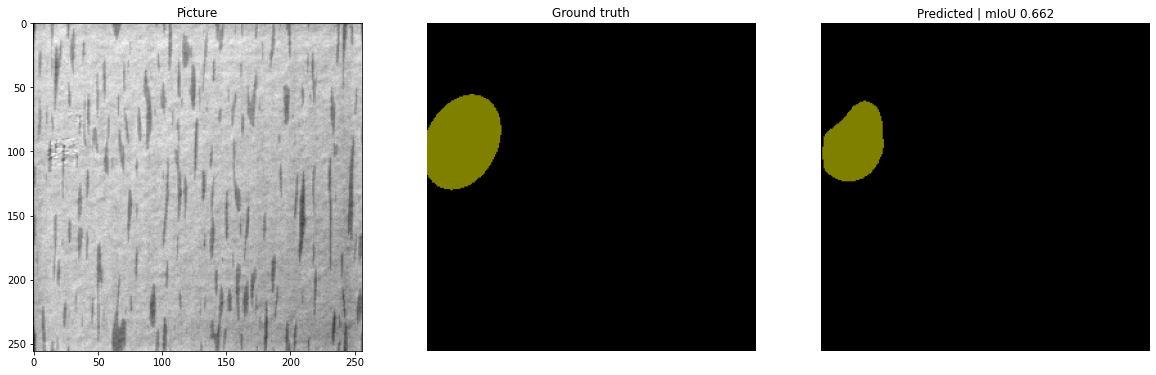

In [23]:
image, mask = test_set[53]
pred_mask, score = predict_image_mask_miou(model, image, mask)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
ax1.imshow(image, cmap='gray')
ax1.set_title('Picture');

ax2.imshow(decode_segmap(mask))
ax2.set_title('Ground truth')
ax2.set_axis_off()

ax3.imshow(decode_segmap(pred_mask))
ax3.set_title('Predicted | mIoU {:.3f}'.format(score))
ax3.set_axis_off()

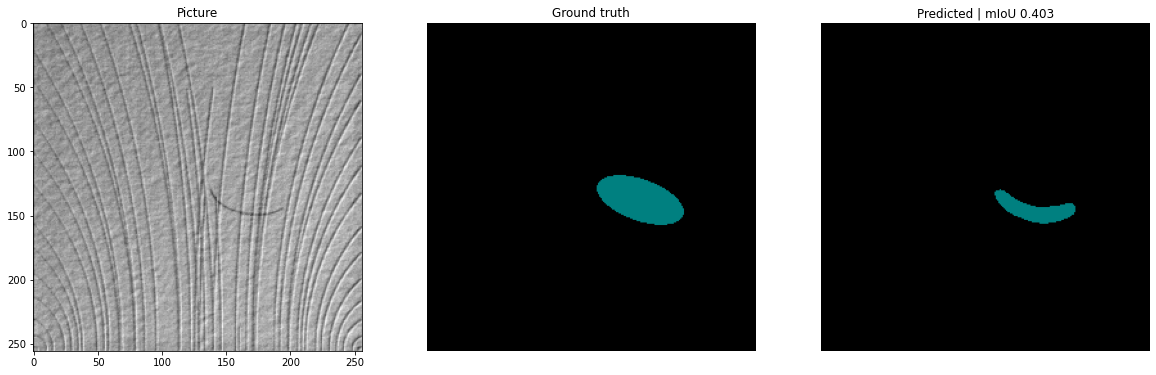

In [24]:
image2, mask2 = test_set[12]
pred_mask2, score2 = predict_image_mask_miou(model, image2, mask2)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
ax1.imshow(image2, cmap='gray')
ax1.set_title('Picture');

ax2.imshow(decode_segmap(mask2))
ax2.set_title('Ground truth')
ax2.set_axis_off()

ax3.imshow(decode_segmap(pred_mask2))
ax3.set_title('Predicted | mIoU {:.3f}'.format(score2))
ax3.set_axis_off()

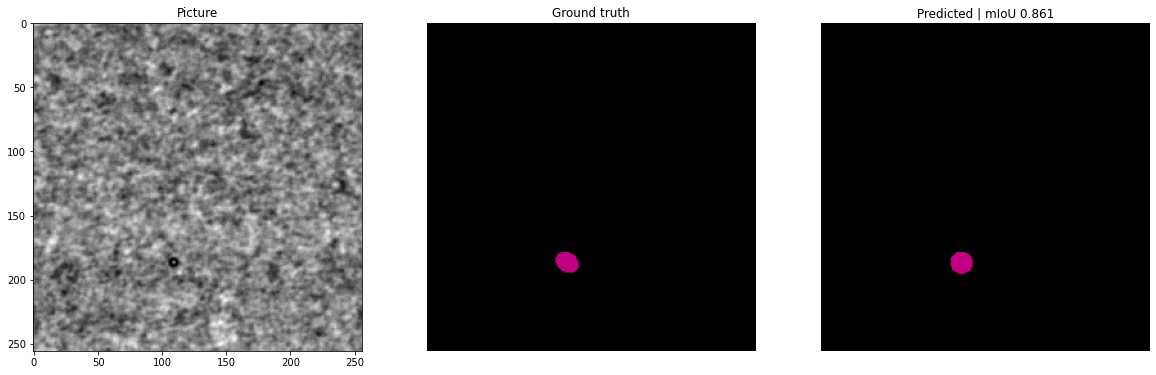

In [25]:
image3, mask3 = test_set[0]
pred_mask3, score3 = predict_image_mask_miou(model, image3, mask3)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
ax1.imshow(image3, cmap='gray')
ax1.set_title('Picture');

ax2.imshow(decode_segmap(mask3))
ax2.set_title('Ground truth')
ax2.set_axis_off()

ax3.imshow(decode_segmap(pred_mask3))
ax3.set_title('Predicted | mIoU {:.3f}'.format(score3))
ax3.set_axis_off()

In [26]:
# import module
from tabulate import tabulate
 
# assign data
Results = [
    ["Score", np.mean(mob_miou)*100, np.mean(mob_mdice)*100, np.mean(mob_acc)*100] 
]
 
# create header
head = ["Metrics", "mIoU(%)", "mDice(%)", "Accuracy(%)"]
 
# display table
print(tabulate(Results, headers=head, tablefmt="fancy_grid"))


╒═══════════╤═══════════╤════════════╤═══════════════╕
│ Metrics   │   mIoU(%) │   mDice(%) │   Accuracy(%) │
╞═══════════╪═══════════╪════════════╪═══════════════╡
│ Score     │   73.4669 │    83.8259 │       99.2139 │
╘═══════════╧═══════════╧════════════╧═══════════════╛
